In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os
from astroNN.nn.layers import MCDropout
import math


Reading JLA covariance matrix and examinate the min, max and mean from it. 

-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


Text(0.5, 1.0, 'Original cov matrix')

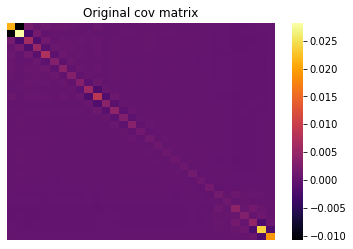

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)
data = np.loadtxt(file, skiprows=3)
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))

sns.heatmap(pd.DataFrame(syscov), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original cov matrix')

Heat map to cov matrix:

In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(data[:,1].reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalerdist.transform(errors.reshape(nsize,1))

Verify that the cov matrix is symmetrical:

In [4]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :] = p
    return matrixset


In [5]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix


def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

In [6]:
magnitudes_sc = matrixMag(syscov_sc)
magnitudes = matrixMag(syscov)


In [7]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov_sc, numMatrix)
print(np.shape(permMatrix))

(10000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX')

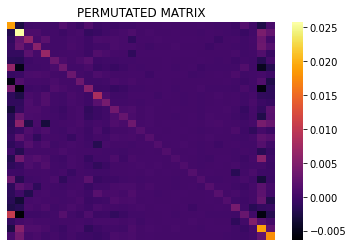

In [8]:
# sns.heatmap(pd.DataFrame(permMatrix[99, :, : ]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [9]:


for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.rand()
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*10**magnitudes_sc[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 1e-4*10**err*magnitudes_sc[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + err*10**magnitudes_sc[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col]  + 10*err*10**magnitudes_sc[row, col]
#                 filled_matrix[row, col] = 0.1*np.random.rand()*10**magnitudes[row, col]


            
#     covset[i,:,:] = scalercov.transform(covset[i,:,:])
#     covset_noise[i,:,:] = scalercov.transform(covset_noise[i,:,:])
            

# covset = scalercov.transform(covset)
# covset_noise = scalercov.transform(covset_noise)

 Generating 927 matrix

 Generating 1426 matrix 

 Generating 2053 matrix 

 Generating 2925 matrix 

 Generating 3819 matrix

 Generating 4815 matrix 

 Generating 5424 matrix

 Generating 5807 matrix

 Generating 6423 matrix

 Generating 6922 matrix 

 Generating 7422 matrix

 Generating 10000 matrix  

In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)



covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))

(10000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

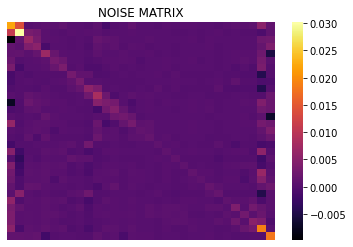

In [11]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_noise_test[10].reshape(31,31))), 
# sns.heatmap(pd.DataFrame(np.exp(covset_test[100])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

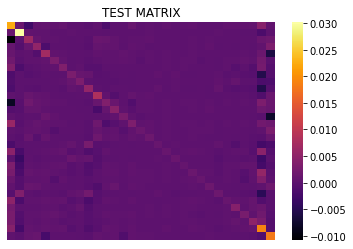

In [12]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_test[10].reshape(31,31))), 
# sns.heatmap(pd.DataFrame(np.exp(covset_test[100])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")
# np.exp(covset_test[0])

## Here starts the VAE network

- Original input is the data len for JLA compilation-
- We try with 3 hidden layer
- We want that the latent space has 1 dimension to make a mapping with the redshift

In [13]:
original_dim = 31*31
intermediate_dim1 = 1000
intermediate_dim2 = 500
intermediate_dim3 = 200
latent_dim = 50



inputs = tf.keras.Input(shape=(original_dim,))

h = layers.Dense(intermediate_dim1, activation='relu')(inputs)
h2 = layers.Dense(intermediate_dim2, activation='relu')(h)
h3 = layers.Dense(intermediate_dim3, activation='relu')(h2)
z_mean = layers.Dense(latent_dim)(h3)
z_log_sigma = layers.Dense(latent_dim)(h3)

### Define a sampling method

In [14]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0.0, stddev=0.05)
    return z_mean + K.exp(z_log_sigma) * epsilon



Create a Lambda layer with z_mean, z_log_sigma and sampling method **

In [15]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [16]:
# Create encoder model
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim1, activation='relu')(latent_inputs)
x2 = layers.Dense(intermediate_dim2, activation='relu')(x)
x3 = layers.Dense(intermediate_dim3, activation='relu')(x2)



# Last layer returns original dimension
outputs = layers.Dense(original_dim, activation='relu')(x3)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')


## Instantiate loss functions

- Reconstruction loss
- Kullback-Leiber divergence
- VAE loss

In [17]:
# reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae_loss = reconstruction_loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### TRAINING

In [18]:
vae_train = vae.fit(covset_train, covset_noise_train,
        epochs=50,
        batch_size=16,
#         shuffle=True,
        validation_data=(covset_test, covset_noise_test))

Epoch 1/50
500/500 [==============================] - 6s 11ms/step - loss: 484.6766 - val_loss: 433.2136
Epoch 2/50
500/500 [==============================] - 5s 10ms/step - loss: 432.5180 - val_loss: 432.2145
Epoch 3/50
500/500 [==============================] - 6s 11ms/step - loss: 432.2015 - val_loss: 431.7485
Epoch 4/50
500/500 [==============================] - 5s 10ms/step - loss: 431.7316 - val_loss: 431.1958
Epoch 5/50
500/500 [==============================] - 5s 10ms/step - loss: 431.0249 - val_loss: 430.6323
Epoch 6/50
500/500 [==============================] - 5s 10ms/step - loss: 430.3561 - val_loss: 430.0727
Epoch 7/50
500/500 [==============================] - 5s 10ms/step - loss: 430.0929 - val_loss: 429.8814
Epoch 8/50
500/500 [==============================] - 5s 10ms/step - loss: 419.5551 - val_loss: 405.9982
Epoch 9/50
500/500 [==============================] - 5s 10ms/step - loss: 405.4336 - val_loss: 405.0851
Epoch 10/50
500/500 [==============================] - 

### Evaluate performance

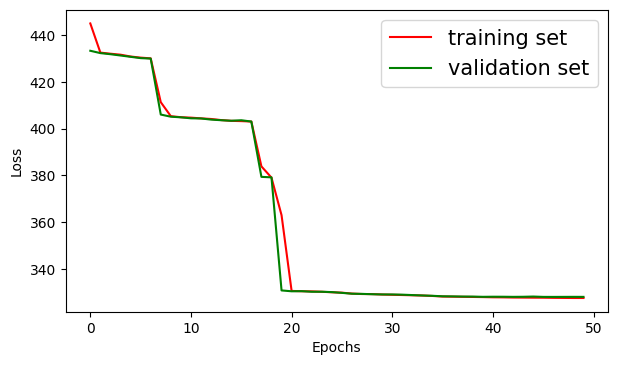

In [19]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(vae_train.history['loss'], color='r')
plt.plot(vae_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)

# plt.legend(['train', 'val'], loc='upper left')

Looking the latent space

In [20]:
# evec_test_encoded = encoder.predict(covset_test)
# # plt.figure(figsize=(6, 6))
# plt.scatter(evec_test_encoded[0], evec_test_encoded[1], c=evec_test_encoded[2])
# plt.colorbar()
# # plt.show()
# print(np.shape(evec_test_encoded), type(evec_test_encoded))
# x_test_encoded = encoder.predict(covset, batch_size=32)
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[0], x_test_encoded[ 1])
# plt.colorbar()
# plt.show()


Analize bounds of latent space:

## Generate synthetic covariance matrix

In [21]:
np.shape(covset_test[0,:].reshape(nsize*nsize,))

(961,)

(1, 961)
(31, 31)


Text(0.5, 1.0, 'Clean matrix')

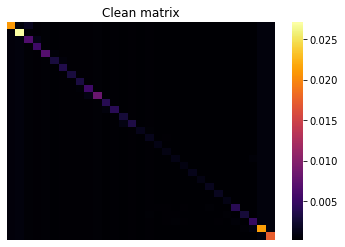

In [22]:
clean_img = vae.predict(covset_test[0,:].reshape(1,nsize*nsize))
# x_test,batch_size=batch_size

print(np.shape(clean_img))
# clean_imgr = np.exp(clean_img.reshape(31,31))
clean_imgr = scalercov.inverse_transform(clean_img.reshape(31,31))
# clean_imgr = symmetrical(clean_imgr)
print(np.shape(clean_imgr))

# clean_imgr = symmetrical(clean_imgr)
sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

In [23]:
# def plot_label_clusters(vae, data, labels):
#     # display a 2D plot of the digit classes in the latent space
#     z_mean, _, _ = encoder.predict(data)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], )
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()


# plot_label_clusters(vae, covset_train[0,:], covset_train)]

In [24]:
filled_matrix = np.zeros((nsize, nsize))
# err = np.random.randn()
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov_sc[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            filled_matrix[row, col] = np.random.rand()*10**magnitudes_sc[row, col] # this work with original syscov
#             filled_matrix[row, col] = 0.001*np.random.rand()

filled_matrix_rec = scalercov.inverse_transform(filled_matrix)
np.shape(filled_matrix)

(31, 31)

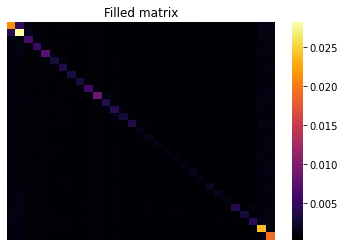

In [25]:
sns.heatmap(pd.DataFrame(filled_matrix_rec), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')
np.savetxt("fake_binned_JLA_COVdecodedTESTfilled.dat", filled_matrix_rec, delimiter= " ", header="#fake COV")


Text(0.5, 1.0, 'Reconstructed matrix with conv-AE')

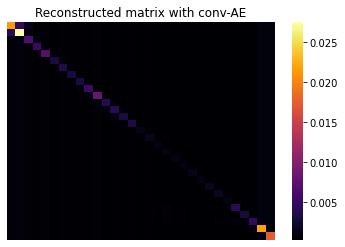

In [26]:
# filled_matrix = scalercov.transform(filled_matrix)
filled_matrix_flat = filled_matrix.reshape(1,31*31)

clean_img = vae.predict(filled_matrix_flat)
# # clean_img = vae.predict(covset_test[0,:].reshape(1,nsize*nsize))

clean_imgr = scalercov.inverse_transform(clean_img.reshape(31,31))
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Reconstructed matrix with conv-AE')

In [27]:
np.savetxt("fake_binned_JLA_COVdecodedTESTVAE.dat", clean_imgr, delimiter= " ", header="#fake COV")


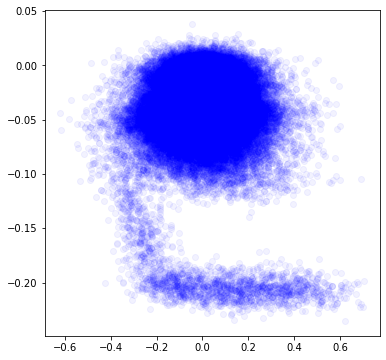

In [33]:
x_test_encoded = encoder.predict(covset_test, batch_size=16)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[ 0], x_test_encoded[1], marker='o', c='blue', alpha=0.05)
# plt.colorbar()
plt.show()
